In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv('student_data.csv')
print(df)

     Self_Study_Daily  Tution_Monthly  Pass_Or_Fail
0                   7              27             1
1                   2              43             0
2                   7              26             1
3                   8              29             1
4                   3              42             0
..                ...             ...           ...
995                 6              22             1
996                 9              30             1
997                 3              39             0
998                 7              25             1
999                 5              37             0

[1000 rows x 3 columns]


In [4]:
X = df[["Self_Study_Daily", "Tution_Monthly"]]
y = df["Pass_Or_Fail"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [6]:
y_pred = model.predict(X_test_scaled)

In [7]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.98


In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [9]:
df = pd.read_csv('StudentsPerformance.csv')
print(df)

     gender race/ethnicity parental level of education         lunch  \
0    female        group B           bachelor's degree      standard   
1    female        group C                some college      standard   
2    female        group B             master's degree      standard   
3      male        group A          associate's degree  free/reduced   
4      male        group C                some college      standard   
..      ...            ...                         ...           ...   
995  female        group E             master's degree      standard   
996    male        group C                 high school  free/reduced   
997  female        group C                 high school  free/reduced   
998  female        group D                some college      standard   
999  female        group D                some college  free/reduced   

    test preparation course  math score  reading score  writing score  
0                      none          72             72         

In [10]:
binary_cols = ["gender", "lunch", "test preparation course"]
label_encoder = LabelEncoder()

for col in binary_cols:
    df[col] = label_encoder.fit_transform(df[col])

df = pd.get_dummies(df, columns=["race/ethnicity", "parental level of education"], drop_first=True)

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

inertia = []
k_range = range(1, 10)

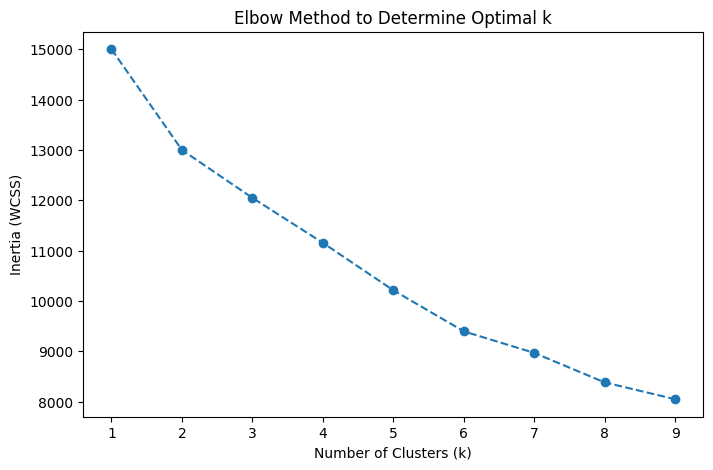

In [12]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method to Determine Optimal k")
plt.show()

In [13]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

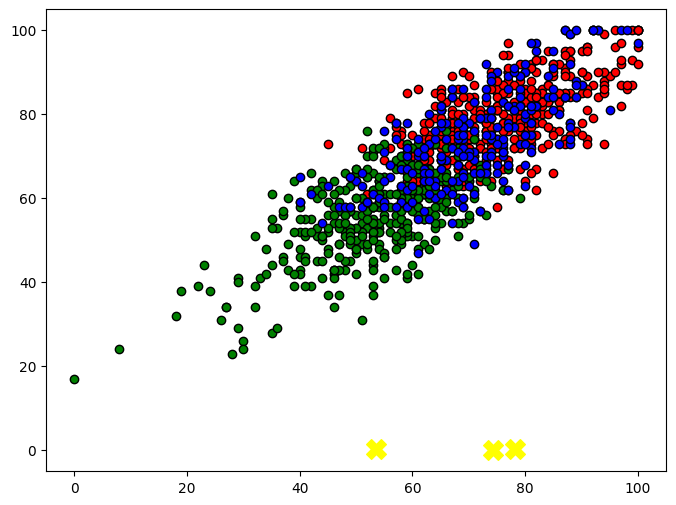

In [14]:
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
for cluster in range(optimal_k):
    clustered_data = df[df["cluster"] == cluster]
    plt.scatter(clustered_data["math score"], clustered_data["reading score"],
                label=f"Cluster {cluster}", color=colors[cluster], edgecolors='black')

centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 5], centers[:, 6], c='yellow', marker='X', s=200, label="Centroids")

In [15]:
import tensorflow as tf
from keras._tf_keras.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from keras import layers

In [ ]:
!unzip dataset.zip

In [17]:
IMG_SIZE = 64
BATCH_SIZE = 32

dataset = image_dataset_from_directory(
    "dataset",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=None
)

Found 2782 files.


In [18]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [19]:
dataset = dataset.map(lambda x: normalize(x))

In [ ]:
generator = keras.Sequential([
    layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((8, 8, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding="same", activation="tanh")
])

discriminator = keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=(64, 64, 3)),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

In [24]:
cross_entropy = keras.losses.BinaryCrossentropy()

In [25]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [27]:
LATENT_DIM = 100

In [26]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [28]:
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])  # Random noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [29]:
def generate_and_save_images(epoch, noise_dim=LATENT_DIM):
    noise = tf.random.normal([1, noise_dim])
    generated_image = generator(noise, training=False)[0]

    plt.imshow(generated_image)
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    plt.show()

In [30]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}")
            generate_and_save_images(epoch + 1)

Epoch 193/500
Epoch 194/500
Epoch 195/500
Epoch 196/500
Epoch 197/500
Epoch 198/500
Epoch 199/500
Epoch 200/500


Epoch 200, Gen Loss: 1.8668, Disc Loss: 0.4003


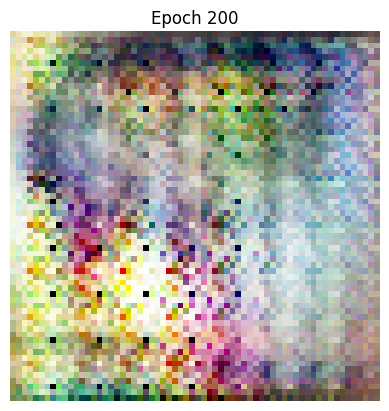

Epoch 201/500
Epoch 202/500
Epoch 203/500
Epoch 204/500
Epoch 205/500
Epoch 206/500
Epoch 207/500
Epoch 208/500
Epoch 209/500
Epoch 210/500
Epoch 211/500
Epoch 212/500
Epoch 213/500
Epoch 214/500
Epoch 215/500
Epoch 216/500
Epoch 217/500
Epoch 218/500
Epoch 219/500
Epoch 220/500
Epoch 221/500
Epoch 222/500
Epoch 223/500
Epoch 224/500
Epoch 225/500
Epoch 226/500
Epoch 227/500
Epoch 228/500
Epoch 229/500
Epoch 230/500
Epoch 231/500
Epoch 232/500
Epoch 233/500
Epoch 234/500
Epoch 235/500
Epoch 236/500
Epoch 237/500
Epoch 238/500
Epoch 239/500
Epoch 240/500
Epoch 241/500
Epoch 242/500
Epoch 243/500
Epoch 244/500
Epoch 245/500
Epoch 246/500
Epoch 247/500
Epoch 248/500
Epoch 249/500
Epoch 250/500
Epoch 251/500
Epoch 252/500
Epoch 253/500
Epoch 254/500
Epoch 255/500
Epoch 256/500
Epoch 257/500
Epoch 258/500
Epoch 259/500
Epoch 260/500
Epoch 261/500
Epoch 262/500
Epoch 263/500
Epoch 264/500
Epoch 265/500
Epoch 266/500
Epoch 267/500
Epoch 268/500
Epoch 269/500
Epoch 270/500
Epoch 271/500
Epoch 

Epoch 300, Gen Loss: 1.0781, Disc Loss: 1.3206


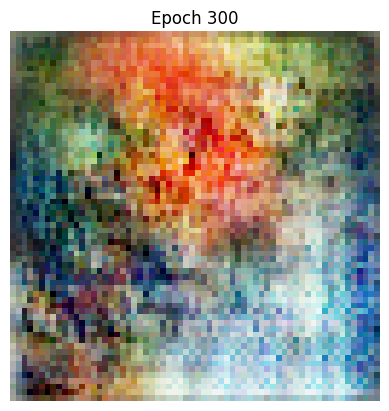

Epoch 301/500
Epoch 302/500
Epoch 303/500
Epoch 304/500
Epoch 305/500
Epoch 306/500
Epoch 307/500
Epoch 308/500
Epoch 309/500
Epoch 310/500
Epoch 311/500
Epoch 312/500
Epoch 313/500
Epoch 314/500
Epoch 315/500
Epoch 316/500
Epoch 317/500
Epoch 318/500
Epoch 319/500
Epoch 320/500
Epoch 321/500
Epoch 322/500
Epoch 323/500
Epoch 324/500
Epoch 325/500
Epoch 326/500
Epoch 327/500
Epoch 328/500
Epoch 329/500
Epoch 330/500
Epoch 331/500
Epoch 332/500
Epoch 333/500
Epoch 334/500
Epoch 335/500
Epoch 336/500
Epoch 337/500
Epoch 338/500
Epoch 339/500
Epoch 340/500
Epoch 341/500
Epoch 342/500
Epoch 343/500
Epoch 344/500
Epoch 345/500
Epoch 346/500
Epoch 347/500
Epoch 348/500
Epoch 349/500
Epoch 350/500
Epoch 351/500


In [ ]:
with tf.device('/GPU:0'):
    train(dataset, 500)